# CIFAR-10 데이터 전처리 및 증강

## 목표
- CIFAR-10 데이터 50,000장 → 150,000장으로 증강
- 3가지 노이즈 타입: S&P, Gaussian, Burst (각 50,000장)
- 5가지 SNR 레벨: -30, -25, -20, -15, -10 dB (균등 분포)
- Burst 노이즈 3가지 종류: Dead Pixels, Column/Row Defects, Block Bursts

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# GPU 메모리 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # GPU 메모리 제한 (8GB)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=8192)]
        )
        print("GPU memory growth enabled and limited to 8GB")
    except RuntimeError as e:
        print(e)

2025-10-27 01:10:12.853642: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 01:10:12.927151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-27 01:10:12.927212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-27 01:10:12.935794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-27 01:10:12.964323: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled and limited to 8GB


2025-10-27 01:10:14.866482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-27 01:10:14.990868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-27 01:10:14.990913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## 1. 노이즈 생성 함수 정의

In [2]:
def add_noise_by_snr(clean_data, snr_db, noise_type='gaussian'):
    """
    특정 SNR로 노이즈 추가
    
    Args:
        clean_data: 깨끗한 데이터 (N, H, W, C) 또는 (N, D)
        snr_db: 목표 SNR (dB)
        noise_type: 'gaussian', 'sp', 'burst'
    
    Returns:
        노이즈가 추가된 데이터
    """
    signal_power = np.mean(clean_data ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)
    
    if noise_type == 'gaussian':
        noise = np.random.normal(0, noise_std, clean_data.shape).astype('float32')
        noisy_data = clean_data + noise
    
    elif noise_type == 'sp':
        # Salt & Pepper noise
        noisy_data = clean_data.copy()
        # SNR 기반으로 노이즈 비율 계산
        noise_ratio = min(0.5, noise_std * 2)  # 최대 50%
        
        # Salt (1.0)
        salt_mask = np.random.random(clean_data.shape) < noise_ratio / 2
        noisy_data[salt_mask] = 1.0
        
        # Pepper (0.0)
        pepper_mask = np.random.random(clean_data.shape) < noise_ratio / 2
        noisy_data[pepper_mask] = 0.0
    
    elif noise_type == 'burst':
        # Burst noise는 별도 함수 사용
        burst_types = ['dead_pixels', 'column_row', 'block']
        burst_type = np.random.choice(burst_types)
        noisy_data = add_burst_noise(clean_data, noise_std, burst_type)
    
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")
    
    return np.clip(noisy_data, 0.0, 1.0).astype('float32')


def add_burst_noise(clean_data, noise_std, burst_type='dead_pixels'):
    """
    Burst 노이즈 추가
    
    Args:
        clean_data: 깨끗한 데이터 (N, H, W, C)
        noise_std: 노이즈 강도
        burst_type: 'dead_pixels', 'column_row', 'block'
    """
    noisy_data = clean_data.copy()
    N, H, W, C = clean_data.shape
    
    # 노이즈 강도에 따라 영향 받는 픽셀 비율 결정
    affected_ratio = min(0.3, noise_std * 3)
    
    if burst_type == 'dead_pixels':
        # 랜덤 위치에 고정값 (dead/stuck pixels)
        for i in range(N):
            num_dead = int(H * W * affected_ratio)
            dead_positions = np.random.choice(H * W, num_dead, replace=False)
            
            for pos in dead_positions:
                row = pos // W
                col = pos % W
                # 50% 확률로 0 또는 1
                noisy_data[i, row, col, :] = np.random.choice([0.0, 1.0])
    
    elif burst_type == 'column_row':
        # Column/Row defects
        for i in range(N):
            num_lines = max(1, int(max(H, W) * affected_ratio / 10))
            
            for _ in range(num_lines):
                if np.random.random() < 0.5:
                    # Column defect
                    col = np.random.randint(0, W)
                    noisy_data[i, :, col, :] = np.random.choice([0.0, 1.0])
                else:
                    # Row defect
                    row = np.random.randint(0, H)
                    noisy_data[i, row, :, :] = np.random.choice([0.0, 1.0])
    
    elif burst_type == 'block':
        # Random block bursts
        for i in range(N):
            num_blocks = max(1, int(10 * affected_ratio))
            
            for _ in range(num_blocks):
                # 랜덤 크기의 블록
                block_h = np.random.randint(2, max(3, H // 4))
                block_w = np.random.randint(2, max(3, W // 4))
                
                # 랜덤 위치
                start_h = np.random.randint(0, H - block_h + 1)
                start_w = np.random.randint(0, W - block_w + 1)
                
                # 블록 노이즈 추가
                block_value = np.random.choice([0.0, 1.0])
                noisy_data[i, start_h:start_h+block_h, start_w:start_w+block_w, :] = block_value
    
    return noisy_data

## 2. CIFAR-10 데이터 로드

In [3]:
# CIFAR-10 데이터 로드
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.cifar10.load_data()

# [0, 1] 정규화
x_train_clean = x_train_orig.astype('float32') / 255.0
x_test_clean = x_test_orig.astype('float32') / 255.0

# 원-핫 인코딩
num_classes = 10
y_train_onehot = keras.utils.to_categorical(y_train_orig, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test_orig, num_classes)

print(f"Original Train shape: {x_train_clean.shape}")
print(f"Original Test shape: {x_test_clean.shape}")
print(f"Train labels shape: {y_train_onehot.shape}")
print(f"Test labels shape: {y_test_onehot.shape}")

Original Train shape: (50000, 32, 32, 3)
Original Test shape: (10000, 32, 32, 3)
Train labels shape: (50000, 10)
Test labels shape: (10000, 10)


## 3. 노이즈 추가 및 데이터 증강

### 구성:
- 50,000장 → 150,000장
- S&P: 50,000장 (33.3%)
- Gaussian: 50,000장 (33.3%)
- Burst: 50,000장 (33.3%)
- 각 노이즈 타입 내에서 5개 SNR 레벨 균등 분포

In [4]:
# 설정
noise_types = ['gaussian', 'sp', 'burst']
snr_levels = [-30, -25, -20, -15, -10]
samples_per_type = 50000  # 각 노이즈 타입당 50,000장
samples_per_snr = samples_per_type // len(snr_levels)  # 10,000장

print(f"Total samples: {len(noise_types) * samples_per_type}")
print(f"Samples per noise type: {samples_per_type}")
print(f"Samples per SNR level: {samples_per_snr}")

# 결과 저장을 위한 리스트
x_train_augmented_list = []
y_train_augmented_list = []
noise_info_list = []

# 진행 상황 추적
total_iterations = len(noise_types) * len(snr_levels)
pbar = tqdm(total=total_iterations, desc="Generating augmented data")

# 각 노이즈 타입에 대해
for noise_type in noise_types:
    # 각 SNR 레벨에 대해
    for snr in snr_levels:
        # 원본 데이터에서 10,000개 샘플링 (복원 추출)
        indices = np.random.choice(len(x_train_clean), samples_per_snr, replace=True)
        x_sampled = x_train_clean[indices]
        y_sampled = y_train_onehot[indices]
        
        # 노이즈 추가
        x_noisy = add_noise_by_snr(x_sampled, snr, noise_type)
        
        # 리스트에 추가
        x_train_augmented_list.append(x_noisy)
        y_train_augmented_list.append(y_sampled)
        
        # 메타정보 저장
        for i in range(samples_per_snr):
            noise_info_list.append({
                'index': len(noise_info_list),
                'noise_type': noise_type,
                'snr_db': snr,
                'original_index': indices[i]
            })
        
        pbar.update(1)
        pbar.set_postfix({'noise': noise_type, 'snr': snr})

pbar.close()

# 리스트를 numpy 배열로 변환
print("\nConcatenating arrays...")
x_train_augmented = np.concatenate(x_train_augmented_list, axis=0)
y_train_augmented = np.concatenate(y_train_augmented_list, axis=0)
noise_info_df = pd.DataFrame(noise_info_list)

print(f"\nAugmented train shape: {x_train_augmented.shape}")
print(f"Augmented labels shape: {y_train_augmented.shape}")
print(f"Noise info shape: {noise_info_df.shape}")

# 데이터 분포 확인
print("\nNoise type distribution:")
print(noise_info_df['noise_type'].value_counts())
print("\nSNR distribution:")
print(noise_info_df['snr_db'].value_counts().sort_index())

Total samples: 150000
Samples per noise type: 50000
Samples per SNR level: 10000


Generating augmented data: 100%|██████████| 15/15 [00:36<00:00,  2.41s/it, noise=burst, snr=-10]  



Concatenating arrays...

Augmented train shape: (150000, 32, 32, 3)
Augmented labels shape: (150000, 10)
Noise info shape: (150000, 4)

Noise type distribution:
noise_type
gaussian    50000
sp          50000
burst       50000
Name: count, dtype: int64

SNR distribution:
snr_db
-30    30000
-25    30000
-20    30000
-15    30000
-10    30000
Name: count, dtype: int64


## 4. 데이터 셔플

In [5]:
# 데이터 셔플
print("Shuffling data...")
shuffle_indices = np.random.permutation(len(x_train_augmented))

x_train_augmented = x_train_augmented[shuffle_indices]
y_train_augmented = y_train_augmented[shuffle_indices]
noise_info_df = noise_info_df.iloc[shuffle_indices].reset_index(drop=True)
noise_info_df['index'] = range(len(noise_info_df))

print("Shuffling complete!")

Shuffling data...
Shuffling complete!


## 5. 테스트 데이터 증강 (10,000 → 30,000)

In [6]:
# 테스트 데이터도 동일하게 증강
test_samples_per_type = 10000
test_samples_per_snr = test_samples_per_type // len(snr_levels)  # 2,000장

x_test_augmented_list = []
y_test_augmented_list = []
test_noise_info_list = []

print("Generating test data...")
pbar = tqdm(total=len(noise_types) * len(snr_levels), desc="Generating test data")

for noise_type in noise_types:
    for snr in snr_levels:
        # 원본 테스트 데이터에서 2,000개 샘플링
        indices = np.random.choice(len(x_test_clean), test_samples_per_snr, replace=True)
        x_sampled = x_test_clean[indices]
        y_sampled = y_test_onehot[indices]
        
        # 노이즈 추가
        x_noisy = add_noise_by_snr(x_sampled, snr, noise_type)
        
        x_test_augmented_list.append(x_noisy)
        y_test_augmented_list.append(y_sampled)
        
        # 메타정보 저장
        for i in range(test_samples_per_snr):
            test_noise_info_list.append({
                'index': len(test_noise_info_list),
                'noise_type': noise_type,
                'snr_db': snr,
                'original_index': indices[i]
            })
        
        pbar.update(1)

pbar.close()

# 배열로 변환
x_test_augmented = np.concatenate(x_test_augmented_list, axis=0)
y_test_augmented = np.concatenate(y_test_augmented_list, axis=0)
test_noise_info_df = pd.DataFrame(test_noise_info_list)

# 셔플
shuffle_indices = np.random.permutation(len(x_test_augmented))
x_test_augmented = x_test_augmented[shuffle_indices]
y_test_augmented = y_test_augmented[shuffle_indices]
test_noise_info_df = test_noise_info_df.iloc[shuffle_indices].reset_index(drop=True)
test_noise_info_df['index'] = range(len(test_noise_info_df))

print(f"\nAugmented test shape: {x_test_augmented.shape}")
print(f"Augmented test labels shape: {y_test_augmented.shape}")

Generating test data...


Generating test data: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]



Augmented test shape: (30000, 32, 32, 3)
Augmented test labels shape: (30000, 10)


## 6. 데이터 시각화

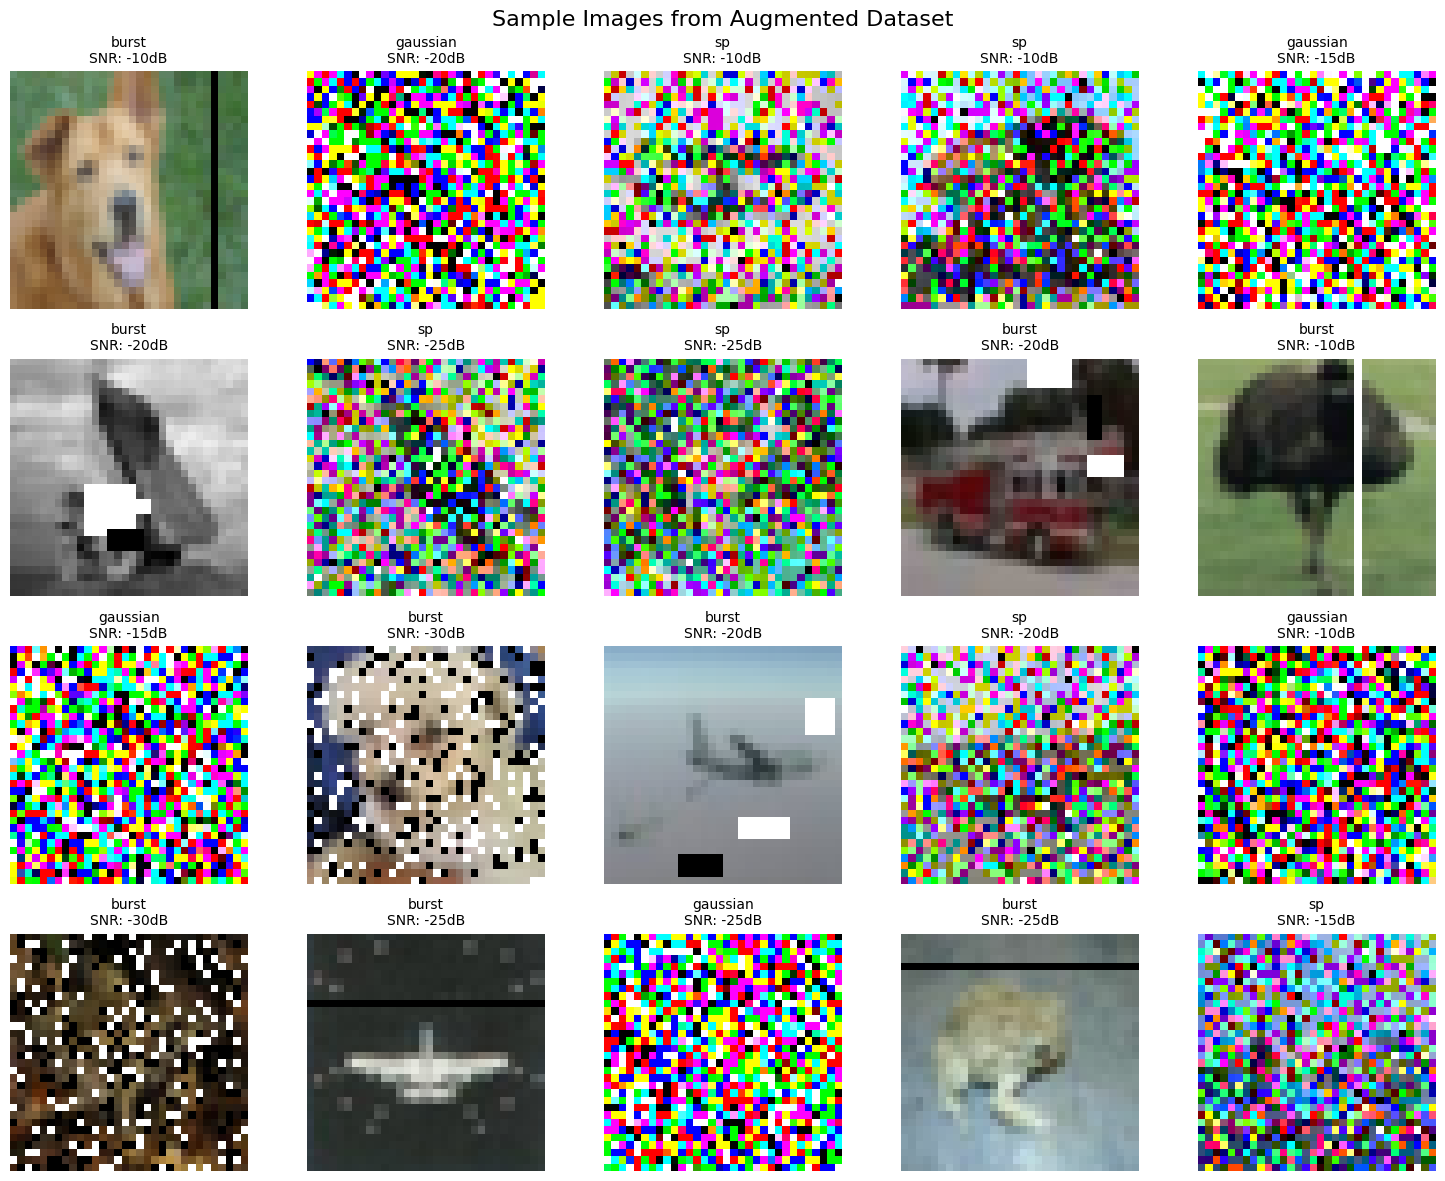

Sample visualization saved as 'augmented_samples.png'


In [7]:
# 샘플 이미지 시각화
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Sample Images from Augmented Dataset', fontsize=16)

sample_indices = np.random.choice(len(x_train_augmented), 20, replace=False)

for idx, ax_idx in enumerate(sample_indices):
    row = idx // 5
    col = idx % 5
    
    img = x_train_augmented[ax_idx]
    noise_type = noise_info_df.loc[ax_idx, 'noise_type']
    snr = noise_info_df.loc[ax_idx, 'snr_db']
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"{noise_type}\nSNR: {snr}dB", fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('augmented_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample visualization saved as 'augmented_samples.png'")

## 7. 데이터 저장

In [8]:
# 저장 디렉토리 생성
os.makedirs('data', exist_ok=True)

print("Saving augmented data...")

# Train data 저장
np.save('data/x_train_augmented.npy', x_train_augmented)
np.save('data/y_train_augmented.npy', y_train_augmented)
np.save('data/x_train_clean.npy', x_train_clean)  # 원본도 저장 (평가용)
noise_info_df.to_csv('data/train_noise_info.csv', index=False)

# Test data 저장
np.save('data/x_test_augmented.npy', x_test_augmented)
np.save('data/y_test_augmented.npy', y_test_augmented)
np.save('data/x_test_clean.npy', x_test_clean)  # 원본도 저장 (평가용)
test_noise_info_df.to_csv('data/test_noise_info.csv', index=False)

print("\nData saved successfully!")
print(f"Train data: data/x_train_augmented.npy ({x_train_augmented.shape})")
print(f"Test data: data/x_test_augmented.npy ({x_test_augmented.shape})")

# 파일 크기 확인
import os

def get_file_size(filepath):
    size_bytes = os.path.getsize(filepath)
    size_mb = size_bytes / (1024 * 1024)
    return size_mb

print("\nFile sizes:")
print(f"x_train_augmented.npy: {get_file_size('data/x_train_augmented.npy'):.2f} MB")
print(f"y_train_augmented.npy: {get_file_size('data/y_train_augmented.npy'):.2f} MB")
print(f"x_test_augmented.npy: {get_file_size('data/x_test_augmented.npy'):.2f} MB")
print(f"y_test_augmented.npy: {get_file_size('data/y_test_augmented.npy'):.2f} MB")

Saving augmented data...

Data saved successfully!
Train data: data/x_train_augmented.npy ((150000, 32, 32, 3))
Test data: data/x_test_augmented.npy ((30000, 32, 32, 3))

File sizes:
x_train_augmented.npy: 1757.81 MB
y_train_augmented.npy: 5.72 MB
x_test_augmented.npy: 351.56 MB
y_test_augmented.npy: 1.14 MB


## 8. 데이터 통계 요약

In [9]:
print("="*60)
print("Data Augmentation Summary")
print("="*60)

print("\n[Training Data]")
print(f"Total samples: {len(x_train_augmented):,}")
print(f"Shape: {x_train_augmented.shape}")
print(f"Data type: {x_train_augmented.dtype}")
print(f"Value range: [{x_train_augmented.min():.3f}, {x_train_augmented.max():.3f}]")

print("\nNoise type distribution:")
for noise_type in noise_types:
    count = (noise_info_df['noise_type'] == noise_type).sum()
    percentage = count / len(noise_info_df) * 100
    print(f"  {noise_type:10s}: {count:6,} ({percentage:5.2f}%)")

print("\nSNR distribution:")
for snr in snr_levels:
    count = (noise_info_df['snr_db'] == snr).sum()
    percentage = count / len(noise_info_df) * 100
    print(f"  {snr:3d} dB: {count:6,} ({percentage:5.2f}%)")

print("\n[Test Data]")
print(f"Total samples: {len(x_test_augmented):,}")
print(f"Shape: {x_test_augmented.shape}")

print("\nNoise type distribution:")
for noise_type in noise_types:
    count = (test_noise_info_df['noise_type'] == noise_type).sum()
    percentage = count / len(test_noise_info_df) * 100
    print(f"  {noise_type:10s}: {count:6,} ({percentage:5.2f}%)")

print("\nSNR distribution:")
for snr in snr_levels:
    count = (test_noise_info_df['snr_db'] == snr).sum()
    percentage = count / len(test_noise_info_df) * 100
    print(f"  {snr:3d} dB: {count:6,} ({percentage:5.2f}%)")

print("\n" + "="*60)
print("Data preprocessing complete!")
print("="*60)

Data Augmentation Summary

[Training Data]
Total samples: 150,000
Shape: (150000, 32, 32, 3)
Data type: float32
Value range: [0.000, 1.000]

Noise type distribution:
  gaussian  : 50,000 (33.33%)
  sp        : 50,000 (33.33%)
  burst     : 50,000 (33.33%)

SNR distribution:
  -30 dB: 30,000 (20.00%)
  -25 dB: 30,000 (20.00%)
  -20 dB: 30,000 (20.00%)
  -15 dB: 30,000 (20.00%)
  -10 dB: 30,000 (20.00%)

[Test Data]
Total samples: 30,000
Shape: (30000, 32, 32, 3)

Noise type distribution:
  gaussian  : 10,000 (33.33%)
  sp        : 10,000 (33.33%)
  burst     : 10,000 (33.33%)

SNR distribution:
  -30 dB:  6,000 (20.00%)
  -25 dB:  6,000 (20.00%)
  -20 dB:  6,000 (20.00%)
  -15 dB:  6,000 (20.00%)
  -10 dB:  6,000 (20.00%)

Data preprocessing complete!
